In [8]:
import numpy as np
np.bool = bool  # quick patch if needed

import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

In [9]:
df = pd.read_csv('/Users/xiaoming/Library/CloudStorage/OneDrive-AsiaPacificUniversity/Degree Y3S2/FYP/retail_store_inventory.csv')

In [10]:
df['Date'] = pd.to_datetime(df['Date'])
df['Day'] = df['Date'].dt.day
df['Month'] = df['Date'].dt.month
df['Year'] = df['Date'].dt.year
df['DayOfWeek'] = df['Date'].dt.dayofweek

In [11]:
df.dtypes

Date                  datetime64[ns]
Store ID                      object
Product ID                    object
Category                      object
Region                        object
Inventory Level                int64
Units Sold                     int64
Units Ordered                  int64
Demand Forecast              float64
Price                        float64
Discount                       int64
Weather Condition             object
Holiday/Promotion              int64
Competitor Pricing           float64
Seasonality                   object
Day                            int32
Month                          int32
Year                           int32
DayOfWeek                      int32
dtype: object

In [12]:
X = df.drop(['Demand Forecast', 'Date','Units Sold'], axis=1)
y = df['Units Sold']

In [13]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)

In [14]:
categorical_features = [
    'Store ID', 'Product ID', 'Category', 'Region',
    'Weather Condition', 'Holiday/Promotion', 'Seasonality'
]

numerical_features = [
    'Inventory Level', 'Units Sold',
    'Price', 'Discount', 'Competitor Pricing',
    'Day', 'Month', 'Year', 'DayOfWeek'
]

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ]
)

In [15]:
X_train_preprocessed = preprocessor.fit_transform(X_train)
X_test_preprocessed = preprocessor.transform(X_test)

# Scale target for better neural net stability
y_scaler = StandardScaler()
y_train_scaled = y_scaler.fit_transform(y_train.values.reshape(-1, 1))
y_test_scaled = y_scaler.transform(y_test.values.reshape(-1, 1))

ValueError: A given column is not a column of the dataframe

In [ ]:
X_train_lstm = X_train_preprocessed.reshape((X_train_preprocessed.shape[0], 1, X_train_preprocessed.shape[1]))
X_test_lstm = X_test_preprocessed.reshape((X_test_preprocessed.shape[0], 1, X_test_preprocessed.shape[1]))

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

model = Sequential()
model.add(LSTM(
    64,
    input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2]),
    return_sequences=False
))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dense(1))  # output layer

model.compile(optimizer='adam', loss='mse', metrics=['mse'])

In [ ]:
from tensorflow.keras import regularizers

model = Sequential()
model.add(LSTM(
    32,
    input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2]),
    return_sequences=False,
    kernel_regularizer=regularizers.l2(0.001)
))
model.add(Dropout(0.3))
model.add(Dense(16, activation='relu'))
model.add(Dense(1))
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
    loss='mse'
)

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    X_train_lstm,
    y_train_scaled,
    epochs=50,
    batch_size=16,
    validation_split=0.2,
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/50


/Users/xiaoming/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2924/2924 ━━━━━━━━━━━━━━━━━━━━ 2s 565us/step - loss: 0.2770 - val_loss: 0.0187
Epoch 2/50
2924/2924 ━━━━━━━━━━━━━━━━━━━━ 2s 521us/step - loss: 0.0286 - val_loss: 0.0114
Epoch 3/50
2924/2924 ━━━━━━━━━━━━━━━━━━━━ 2s 537us/step - loss: 0.0205 - val_loss: 0.0120
Epoch 4/50
2924/2924 ━━━━━━━━━━━━━━━━━━━━ 2s 525us/step - loss: 0.0177 - val_loss: 0.0120
Epoch 5/50
2924/2924 ━━━━━━━━━━━━━━━━━━━━ 2s 539us/step - loss: 0.0170 - val_loss: 0.0096
Epoch 6/50
2924/2924 ━━━━━━━━━━━━━━━━━━━━ 2s 524us/step - loss: 0.0167 - val_loss: 0.0096
Epoch 7/50
2924/2924 ━━━━━━━━━━━━━━━━━━━━ 2s 515us/step - loss: 0.0164 - val_loss: 0.0108
Epoch 8/50
2924/2924 ━━━━━━━━━━━━━━━━━━━━ 2s 541us/step - loss: 0.0160 - val_loss: 0.0106
Epoch 9/50
2924/2924 ━━━━━━━━━━━━━━━━━━━━ 2s 524us/step - loss: 0.0160 - val_loss: 0.0100
Epoch 10/50
2924/2924 ━━━━━━━━━━━━━━━━━━━━ 2s 523us/step - loss: 0.0159 - val_loss: 0.0094
Epoch 11/50
2924/2924 ━━━━━━━━━━━━━━━━━━━━ 2s 544us/step - loss: 0.0156 - val_loss: 0.0119
Epoch 12/50
2924/29

In [ ]:
y_pred_scaled = model.predict(X_test_lstm)
y_pred = y_scaler.inverse_transform(y_pred_scaled).flatten()

457/457 ━━━━━━━━━━━━━━━━━━━━ 0s 382us/step


In [ ]:
y_pred

array([ 83.44041 , 278.84106 , 206.4382  , ...,  39.59986 , 263.7985  ,
        11.315782], dtype=float32)

In [ ]:
y_test

58480     74.30
58481    273.25
58482    190.98
58483     28.53
58484    375.38
          ...  
73095     18.46
73096     48.43
73097     39.65
73098    270.52
73099      2.33
Name: Demand Forecast, Length: 14620, dtype: float64

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R²: {r2:.4f}")

RMSE: 9.5196
MAE: 8.0349
R²: 0.9923


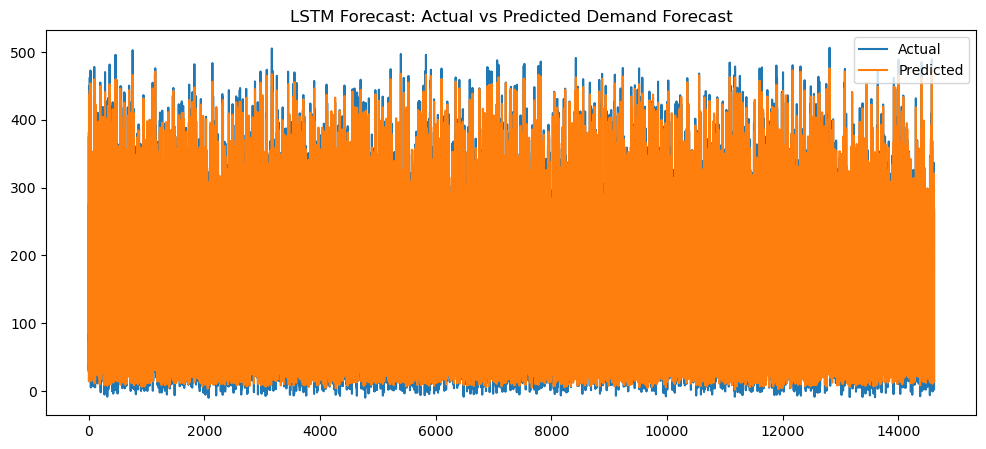

In [ ]:
plt.figure(figsize=(12,5))
plt.plot(y_test.values, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.legend()
plt.title('LSTM Forecast: Actual vs Predicted Demand Forecast')
plt.show()

In [ ]:
threshold = 200

y_test_class = (y_test > threshold).astype(int)
y_pred_class = (y_pred > threshold).astype(int)

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, auc
import matplotlib.pyplot as plt

threshold = 200

y_test_class = (y_test > threshold).astype(int)
y_pred_class = (y_pred > threshold).astype(int)

# Confusion Matrix
cm = confusion_matrix(y_test_class, y_pred_class)
print("Confusion Matrix:")
print(cm)

# Classification Report
print("\nClassification Report:")
print(classification_report(y_test_class, y_pred_class))

Confusion Matrix:
[[10671    73]
 [  188  3688]]

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.99     10744
           1       0.98      0.95      0.97      3876

    accuracy                           0.98     14620
   macro avg       0.98      0.97      0.98     14620
weighted avg       0.98      0.98      0.98     14620



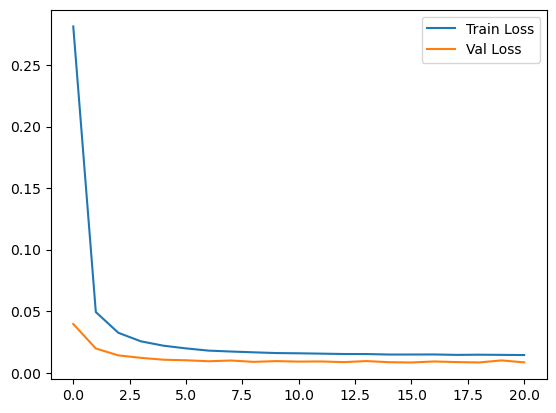

In [ ]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.show()

In [ ]:
df['Units Sold'] = np.log1p(df['Units Sold'])  # log1p handles log(0)

In [ ]:
df['Units Sold'] = np.sqrt(df['Units Sold'])

In [ ]:
#testing